In [3]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
from torch.optim.lr_scheduler import StepLR

from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
class Multiscale1DFitter(nn.Module):

    def __init__(self, function, x_data, input_channels, num_params, scaler=None,
                 post_processing=None, device='cuda', loops_scaler=None, **kwargs):
        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # Swap axes 1 and 2
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)

        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        unscaled_param = embedding

        if self.scaler is not None:
            unscaled_param = (embedding * torch.tensor(self.scaler.var_ ** 0.5).to(self.device)
                              + torch.tensor(self.scaler.mean_).to(self.device))
        else:
            unscaled_param = embedding

        fits = self.function(unscaled_param, self.x_data, device=self.device)
        out = fits

        if self.post_processing is not None:
            out = self.post_processing.compute(fits)
        else:
            out = fits

        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        return out_scaled, unscaled_param

In [44]:
'''class Quadratic_func:
    def __init__(self, x, a=[-1,1], b=[-1,1], c=[-1,1], size=(1,1), batch_size=10000, device="cuda"):
        self.x = x
        self.a = a
        self.b = b
        self.c = c
        self.size = size
        self.batch_size = batch_size
        self.device = device

    def compute(self, params):
        out = torch.zeros((params.shape[0], self.x.shape[0], self.size[0], self.size[1])) # (number parameter sets, number x values, dimensions)
        params = params.to(self.device)
        _a = params[:, 0, 0, 0]
        _b = params[:, 0, 1, 0]
        _c = params[:, 0, 2, 0]
        print(f"_a: {_a.shape}")
        x = torch.cat(params.shape[0]*[self.x]).reshape(params.shape[0], -1).to(self.device) # (number parameter sets, number of x values)
        print(f"x: {x.shape}")

        _out = _a*x**2 + _b*x + _c # (number of parameter sets, number of x values)
        print(f"_out shape: {_out.shape}")
        print(f"_out: {_out}")
        print(f"_out transposed: {torch.transpose(_out,0,1)}")
        # out[:, :, 0, 0] = torch.transpose(_out, 0, 1) # (number of x values, number parameter sets, dimensions)
        out[:, :, 0, 0] = _out
        print(f"out: {out.shape}")
        print(f"out: {out[0]}")
        return (torch.sum(out, dim=3), out)
    
    def sampler(self):
        a = rand_tensor(min=self.a[0], max=self.a[1], size=(self.batch_size, self.size[0], self.size[1]))
        b = rand_tensor(min=self.b[0], max=self.b[1], size=(self.batch_size, self.size[0], self.size[1]))
        c = rand_tensor(min=self.c[0], max=self.c[1], size=(self.batch_size, self.size[0], self.size[1]))

        _params = torch.torch.stack((a, b, c))
        print(f"_Params Stacked: {_params.shape}")
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        print(f"_Params Transposed: {_params.shape}")

        return (self.compute(_params), _params)
    
    def generate(self):
        a = rand_tensor(min=self.a[0], max=self.a[1], size=(self.batch_size, self.size[0], self.size[1]))
        b = rand_tensor(min=self.b[0], max=self.b[1], size=(self.batch_size, self.size[0], self.size[1]))
        c = rand_tensor(min=self.c[0], max=self.c[1], size=(self.batch_size, self.size[0], self.size[1]))
        return a*self.x**2 + b*self.x + c
'''

'class Quadratic_func:\n    def __init__(self, x, a=[-1,1], b=[-1,1], c=[-1,1], size=(1,1), batch_size=10000, device="cuda"):\n        self.x = x\n        self.a = a\n        self.b = b\n        self.c = c\n        self.size = size\n        self.batch_size = batch_size\n        self.device = device\n\n    def compute(self, params):\n        out = torch.zeros((params.shape[0], self.x.shape[0], self.size[0], self.size[1])) # (number parameter sets, number x values, dimensions)\n        params = params.to(self.device)\n        _a = params[:, 0, 0, 0]\n        _b = params[:, 0, 1, 0]\n        _c = params[:, 0, 2, 0]\n        print(f"_a: {_a.shape}")\n        x = torch.cat(params.shape[0]*[self.x]).reshape(params.shape[0], -1).to(self.device) # (number parameter sets, number of x values)\n        print(f"x: {x.shape}")\n\n        _out = _a*x**2 + _b*x + _c # (number of parameter sets, number of x values)\n        print(f"_out shape: {_out.shape}")\n        print(f"_out: {_out}")\n        pr

In [50]:
class Quadratic_func:
    def __init__(self, x, a=[0,1], b=[0,1], c=[0,1], size=(1,1), batch_size=1000, device="cuda"):
        self.x = x
        self.a = a
        self.b = b
        self.c = c
        self.size = size
        self.batch_size = batch_size
        self.device = device

    def compute(self, params):
        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(self.device)
        _a = params[:, 0, 0, 0]
        _b = params[:, 0, 1, 0]
        _c = params[:, 0, 2, 0]
        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
            )
        x = torch.transpose(x, 0, 1).to(self.device)

        _out = _a * x**2 + _b * x + _c
        out[:, :, 0, 0] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self):
        a = rand_tensor(
            min=self.a[0],
            max=self.a[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        b = rand_tensor(
            min=self.b[0],
            max=self.b[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        c = rand_tensor(
            min=self.c[0],
            max=self.c[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        _params = torch.torch.stack((a, b, c))
        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        
        return (self.compute(_params), _params)

In [51]:
sample_size = 10
x_values = torch.linspace(-1, 1, sample_size)
constructor = Quadratic_func(x=x_values, batch_size=sample_size, device=device)
output = constructor.sampler()
spectra, params = output
spectra_full, spectras = spectra


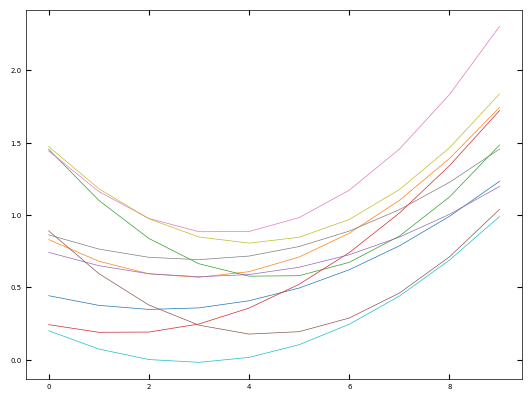

In [56]:
for i in range(10):
   plt.plot(spectra_full[i, :, 0], "-")

In [56]:
def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
    b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
    c = params[:, 2].type(torch.float).unsqueeze(1).to(device)

    return a*x**2 + b*x + c

torch.Size([3, 100])


/tmp/ipykernel_507539/805902740.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lines = quadratic_function(torch.tensor(([1,1,1],[1,1,1],[1,1,1])), torch.tensor(xs), device)


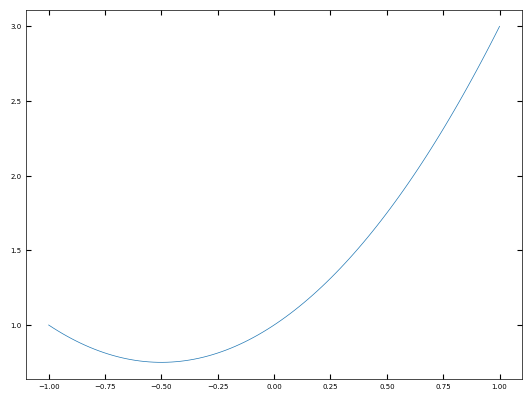

In [60]:
xs = torch.linspace(-1, 1, 100)
lines = quadratic_function(torch.tensor(([1,1,1],[1,1,1],[1,1,1])), torch.tensor(xs), device)
print(lines.shape)
plt.plot(xs, lines[1].detach().cpu().numpy())
